In [1]:
from http.server import BaseHTTPRequestHandler, HTTPServer
import socketserver
import pickle
import urllib.request
import json
from pprint import pprint
from pandas.io.json import json_normalize
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from math import sqrt
import os
import errno
from pymongo import MongoClient
import urllib.parse as urlparse
from influxdb import InfluxDBClient
from pymongo import MongoClient
import pandas as pd
from pandas.io.json import json_normalize
import csv
import matplotlib.pylab as plt


In [29]:
def getAllNodeNames(client):
    queryResult = client.query("SHOW TAG VALUES FROM uptime WITH KEY=nodename;")
    nodeNames_temp = list(queryResult.get_points())
    dfnodeNames = pd.DataFrame(nodeNames_temp)
    allNodeNames = dfnodeNames[:]["value"]
    return allNodeNames
def getNamespaceNames(client,node):
    nsQuery = client.query("SHOW TAG VALUES FROM uptime WITH KEY=namespace_name WHERE nodename = '"+node+"';")
    nsQuery_temp = list(nsQuery.get_points())
    dfnsNames = pd.DataFrame(nsQuery_temp)
    allnsNames = dfnsNames[:]["value"]
    return allnsNames
def getAllPodNames(client,node,ns_name):
    queryResult = client.query("SHOW TAG VALUES FROM uptime WITH KEY = pod_name WHERE namespace_name = '"+ns_name+"' AND nodename = '"+node+"';")
    podNames_temp = list(queryResult.get_points())
    dfpodNames = pd.DataFrame(podNames_temp)
    if dfpodNames.empty:
        return dfpodNames
    else:
        allpodNames = dfpodNames[:]["value"]
        return allpodNames
def getCPUUtilizationNode(client, node):
    queryResult = client.query('SELECT * FROM "cpu/node_utilization" where nodename = \''+node+'\' AND type=\'node\';')
    dfcpuUtilization = pd.DataFrame(queryResult['cpu/node_utilization'])
    return dfcpuUtilization
def getCPUUtilizationPod(client, node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "cpu/usage_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfcpuUtilization = pd.DataFrame(queryResult['cpu/usage_rate'])
    return dfcpuUtilization
def getCPUUtilizationPodContainer(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "cpu/usage_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\' AND type=\'pod_container\';')
    dfcpuUtilization = pd.DataFrame(queryResult['cpu/usage_rate'])
    return dfcpuUtilization
def prepareCpuUtilization(client,node,ns_name, pod_name):
    cpuUtilization = getCPUUtilizationNode(client,node)
    podCpuUtilization = getCPUUtilizationPod(client,node,ns_name, pod_name)
    containercpuUtilization = getCPUUtilizationPodContainer(client,node,ns_name, pod_name)
    plt.plot(cpuUtilization.index, cpuUtilization['value'] *1000, 'r', label="node") # plotting t, a separately
    plt.plot(podCpuUtilization.index, podCpuUtilization['value'], 'b', label="pod") # plotting t, b separately
    plt.plot(containercpuUtilization.index, containercpuUtilization['value'], 'g', label="container") # plotting t, c separately
    plt.legend(loc='upper left')
    plt.show()
def getMemoryUtilizationNode(client,node):
    queryResult = client.query('SELECT * FROM "memory/node_utilization" where nodename = \''+node+'\' AND type=\'node\';')
    dfmemUtilization = pd.DataFrame(queryResult['memory/node_utilization'])
    return dfmemUtilization
def getMemoryUtilizationPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "memory/usage" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['memory/usage'])
    return dfmemUtilization
def getMemoryUtilizationPodContainer(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "memory/usage" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\' AND type=\'pod_container\';')
    dfmemUtilization = pd.DataFrame(queryResult['memory/usage'])
    return dfmemUtilization
def prepareMemoryUtilization(client,node,ns_name, pod_name):
    memoryUtilization = getMemoryUtilizationNode(client,node)
    podMemoryUtilization = getMemoryUtilizationPod(client,node,ns_name, pod_name)
    containerMemoryUtilization = getMemoryUtilizationPodContainer(client,node,ns_name, pod_name)
    plt.plot(memoryUtilization.index, memoryUtilization['value'], 'r', label="node") # plotting t, a separately
    plt.plot(podMemoryUtilization.index, podMemoryUtilization['value'], 'b', label="pod") # plotting t, b separately
    plt.plot(containerMemoryUtilization.index, containerMemoryUtilization['value'], 'g', label="container") # plotting t, c separately
    plt.legend(loc='upper left')
    plt.show()
def getNetworkTxRatePod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/tx_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/tx_rate'])
    return dfmemUtilization
def getNetworkTxPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/tx" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/tx'])
    return dfmemUtilization
def getNetworkTxErrorsPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/tx_errors" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/tx_errors'])
    return dfmemUtilization
def getNetworkTxErrorsRatePod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/tx_errors_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/tx_errors_rate'])
    return dfmemUtilization
def prepareNetworkTxRateUtilization(client,node,ns_name, pod_name):
    podNetworTxRate = getNetworkTxRatePod(client,node,ns_name, pod_name)
    podNetworTx = getNetworkTxPod(client,node,ns_name, pod_name)
    podNetworkError = getNetworkTxErrorsPod(client,node,ns_name, pod_name)
    podNetworkErrorRate = getNetworkTxErrorsRatePod(client,node,ns_name, pod_name)
    plt.plot(podNetworTxRate.index, podNetworTxRate['value'], 'b') # plotting t, b separately
    #plt.plot(podNetworTx.index, podNetworTx['value'], 'g') # plotting t, b separately
    #plt.plot(podNetworkError.index, podNetworkError['value'], 'y') # plotting t, b separately
    plt.plot(podNetworkErrorRate.index, podNetworkErrorRate['value'], 'r') # plotting t, b separately
    plt.show()
def getNetworkRxRatePod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/rx_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/rx_rate'])
    return dfmemUtilization
def getNetworkRxPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/rx" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/rx'])
    return dfmemUtilization

def getNetworkRxErrorsPod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/rx_errors" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/rx_errors'])
    return dfmemUtilization
def getNetworkRxErrorsRatePod(client,node,ns_name, pod_name):
    queryResult = client.query('SELECT * FROM "network/rx_errors_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
    dfmemUtilization = pd.DataFrame(queryResult['network/rx_errors_rate'])
    return dfmemUtilization
def prepareNetworkRxRateUtilization(client,node,ns_name, pod_name):
    podNetworRxRate = getNetworkRxRatePod(client,node,ns_name, pod_name)
    podNetworRx = getNetworkRxPod(client,node,ns_name, pod_name)
    podNetworkError = getNetworkRxErrorsPod(client,node,ns_name, pod_name)
    podNetworkErrorRate = getNetworkRxErrorsRatePod(client,node,ns_name, pod_name)
    plt.plot(podNetworRxRate.index, podNetworRxRate['value'], 'b') # plotting t, b separately
    #plt.plot(podNetworRx.index, podNetworRx['value'], 'g') # plotting t, b separately
    #plt.plot(podNetworkError.index, podNetworkError['value'], 'y') # plotting t, b separately
    plt.plot(podNetworkErrorRate.index, podNetworkErrorRate['value'], 'r') # plotting t, b separately
    plt.show()
def getRelevantNodeName(client,ns_name):
    allNodeNames  = getAllNodeNames(client)
    #nsNames = getNamespaceNames(allNodeNames[0])
    relevantNodes = []
    for node in allNodeNames:
        allPodNamesNode = getAllPodNames(client,node,'default')
        if(not allPodNamesNode.empty):
            relevantNodes.append(node)
    return relevantNodes

def getNodeResourceUtilizationDf(client, nodeName):
    Result_node_CPU = client.query("SELECT value from \"cpu/node_utilization\" where nodename = '"+nodeName+"' AND type = 'node' ")
    Result_node_MEM = client.query("SELECT value from \"memory/node_utilization\" where nodename = '"+nodeName+"' AND type = 'node' ")

    Result_node_CPU_Cores = client.query("SELECT mean(\"value\") FROM \"cpu/node_capacity\" where nodename = '"+nodeName+
                                         "' AND type = 'node' GROUP BY time(1m)")
    Result_node_mem_node = client.query("SELECT mean(\"value\")FROM \"memory/node_capacity\" where nodename = '"+
                                        nodeName+"' AND type = 'node' GROUP BY time(1m)")

    cpu_points = pd.DataFrame(Result_node_CPU.get_points())
    cpu_points['time'] = pd.to_datetime(cpu_points['time'])
    cpu_points = cpu_points.set_index('time')
    cpu_points.columns = ['node_cpu_util']
    mem_points = pd.DataFrame(Result_node_MEM.get_points())
    mem_points['time'] = pd.to_datetime(mem_points['time'])
    mem_points = mem_points.set_index('time')
    mem_points.columns = ['node_mem_util']

    cores_points = pd.DataFrame(Result_node_CPU_Cores.get_points())
    cores_points['time'] = pd.to_datetime(cores_points['time'])
    cores_points = cores_points.set_index('time')
    cores_points.columns = ['node_cores']

    mem_node_points = pd.DataFrame(Result_node_mem_node.get_points())
    mem_node_points['time'] = pd.to_datetime(mem_node_points['time'])
    mem_node_points = mem_node_points.set_index('time')
    mem_node_points.columns = ['node_mem']

    df_node =pd.concat([cpu_points, mem_points,cores_points,mem_node_points], axis=1)
    return df_node
def getPodResourceUtilizationDf(client, node, ns_name, pod_name):
    Result_Pod_CPU_usage = client.query('SELECT value FROM "cpu/usage_rate" where nodename = \''+node+
                                        '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                        '\'  AND type=\'pod\';')
    Result_Pod_MEM_usage = client.query('SELECT value from \"memory/usage\" where nodename = \''+node+
                                        '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                        '\'  AND type=\'pod\';')

    Result_Pod_CPU_limit = client.query('SELECT mean(\"value\") FROM "cpu/limit" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\' group by time(1m);')
    Result_Pod_MEM_limit = client.query('SELECT mean(\"value\") from \"memory/limit\" where nodename = \''+node+
                                        '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                        '\'  AND type=\'pod\' group by time(1m);')

    Result_Pod_CPU_requests = client.query('SELECT mean(\"value\") FROM "cpu/request" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\' group by time(1m);')
    Result_Pod_MEM_requests = client.query('SELECT mean(\"value\") from \"memory/request\" where nodename = \''+node+
                                           '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                           '\'  AND type=\'pod\' group by time(1m);')


    cpu_points_usage = pd.DataFrame(Result_Pod_CPU_usage.get_points())
    cpu_points_usage['time'] = pd.to_datetime(cpu_points_usage['time'])
    cpu_points_usage = cpu_points_usage.set_index('time')
    cpu_points_usage.columns = ['pod_cpu_usage']


    mem_points_usage = pd.DataFrame(Result_Pod_MEM_usage.get_points())
    mem_points_usage['time'] = pd.to_datetime(mem_points_usage['time'])
    mem_points_usage = mem_points_usage.set_index('time')
    mem_points_usage.columns = ['pod_mem_usage']


    cpu_points_limits = pd.DataFrame(Result_Pod_CPU_limit.get_points())
    cpu_points_limits['time'] = pd.to_datetime(cpu_points_limits['time'])
    cpu_points_limits = cpu_points_limits.set_index('time')
    cpu_points_limits.columns = ['pod_cpu_limit']


    mem_points_limits = pd.DataFrame(Result_Pod_MEM_limit.get_points())
    mem_points_limits['time'] = pd.to_datetime(mem_points_limits['time'])
    mem_points_limits = mem_points_limits.set_index('time')
    mem_points_limits.columns = ['pod_mem_limit']


    cpu_points_request = pd.DataFrame(Result_Pod_CPU_requests.get_points())
    cpu_points_request['time'] = pd.to_datetime(cpu_points_request['time'])
    cpu_points_request = cpu_points_request.set_index('time')
    cpu_points_request.columns = ['pod_cpu_request']


    mem_points_request = pd.DataFrame(Result_Pod_MEM_requests.get_points())
    mem_points_request['time'] = pd.to_datetime(mem_points_request['time'])
    mem_points_request = mem_points_request.set_index('time')
    mem_points_request.columns = ['pod_mem_request']

    df_pod =pd.concat([cpu_points_usage, mem_points_usage,cpu_points_limits,mem_points_limits,cpu_points_request,mem_points_request ], axis=1)

    return df_pod
def getRequestsDf(clientK6):
    queryResult = clientK6.query('SELECT sum("value") FROM "vus" group by time(1m);')
    vus = pd.DataFrame(queryResult['vus'])
    vus.columns = ['vus','time']
    vus = vus.set_index('time')


    queryResultReqs = clientK6.query('SELECT sum("value") FROM "http_reqs" group by time(1m);')
    reqs = pd.DataFrame(queryResultReqs['http_reqs'])
    reqs.columns = ['requests','time']
    reqs = reqs.set_index('time')
    queryResultReqsDuration95 = clientK6.query('SELECT percentile("value", 95) FROM "http_req_duration" group by time(1m) ;')
    reqs_duration95 = pd.DataFrame(queryResultReqsDuration95['http_req_duration'])
    reqs_duration95.columns = [ 'requests_duration_percentile_95','time']
    reqs_duration95 = reqs_duration95.set_index('time')
    queryResultReqsDuration90 = clientK6.query('SELECT percentile("value", 90) FROM "http_req_duration" group by time(1m) ;')
    reqs_duration90 = pd.DataFrame(queryResultReqsDuration90['http_req_duration'])
    reqs_duration90.columns = ['requests_duration_percentile_90','time']
    reqs_duration90 = reqs_duration90.set_index('time')

    queryResultMaxDuration = clientK6.query('SELECT max("value") FROM "http_req_duration" group by time(1m);')
    reqs_duration_max = pd.DataFrame(queryResultMaxDuration['http_req_duration'])
    reqs_duration_max.columns = ['requests_duration_max','time']
    reqs_duration_max = reqs_duration_max.set_index('time')

    queryResultMinDuration = clientK6.query('SELECT min("value") FROM "http_req_duration" group by time(1m);')
    reqs_duration_min = pd.DataFrame(queryResultMinDuration['http_req_duration'])
    reqs_duration_min.columns = ['requests_duration_min','time']
    reqs_duration_min = reqs_duration_min.set_index('time')

    queryResultMeanDuration = clientK6.query('SELECT mean("value") FROM "http_req_duration" group by time(1m);')
    reqs_duration_mean = pd.DataFrame(queryResultMeanDuration['http_req_duration'])
    reqs_duration_mean.columns = ['requests_duration_mean','time']
    reqs_duration_mean = reqs_duration_mean.set_index('time')

    queryResultMedianDuration = clientK6.query('SELECT median("value") FROM "http_req_duration" group by time(1m);')
    reqs_duration_median = pd.DataFrame(queryResultMedianDuration['http_req_duration'])
    reqs_duration_median.columns = ['requests_duration_median','time']
    reqs_duration_median = reqs_duration_median.set_index('time')

    finalDF = pd.merge(vus, reqs, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF, reqs_duration95, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF, reqs_duration90, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF,reqs_duration_max, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF,reqs_duration_min, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF,reqs_duration_mean, left_index=True, right_index=True)
    finalDF = pd.merge(finalDF,reqs_duration_median, left_index=True, right_index=True)
    finalDF.index = pd.to_datetime(finalDF.index)

    return finalDF

def getPodsNodesRequestsDf(appNames, client,  clientK6):
    default_ns_name =  "default"
    df_pods_node = []
    relevantNodeNames = getRelevantNodeName(client,default_ns_name)
    for relevantNodeName in relevantNodeNames:
        if relevantNodeName is not None:
            podNames = getAllPodNames(client,relevantNodeName, default_ns_name)
            df_node = getNodeResourceUtilizationDf(client,relevantNodeName)
            for podName in podNames:
                for appName in appNames:
                    if appName in podName:
                        df_pod = getPodResourceUtilizationDf(client,relevantNodeName, default_ns_name, podName)
                        finalDF = pd.merge(df_node,df_pod, left_index=True, right_index=True)
                        requestsDF = getRequestsDf(clientK6)
                        finalDF = pd.merge(finalDF,requestsDF, left_index=True, right_index=True)
                        if(finalDF['pod_cpu_limit'].values[0]==0):
                            finalDF['pod_cpu_usage'] = finalDF['pod_cpu_usage']/(finalDF['node_cores'])
                            finalDF['pod_cpu_limit'] = finalDF['node_cores']/1000
                            finalDF['pod_cpu_request'] = finalDF['node_cores']/1000
                        else:
                            finalDF['pod_cpu_usage'] = finalDF['pod_cpu_usage']/(finalDF['pod_cpu_limit'])
                            finalDF['pod_cpu_limit'] = finalDF['pod_cpu_limit']/1000
                            finalDF['pod_cpu_request'] = finalDF['pod_cpu_request']/1000

                        if(finalDF['pod_mem_limit'].values[0]==0):
                            finalDF['pod_mem_usage'] = finalDF['pod_mem_usage']/(finalDF['node_mem'])
                            finalDF['pod_mem_limit'] = finalDF['node_mem']/(1073741824)
                            finalDF['pod_mem_request'] = finalDF['node_mem']/(1073741824)
                        else:
                            finalDF['pod_mem_usage'] = finalDF['pod_mem_usage']/(finalDF['pod_mem_limit'])
                            finalDF['pod_mem_limit'] = finalDF['pod_mem_limit']/(1073741824)
                            finalDF['pod_mem_request'] = finalDF['pod_mem_request']/(1073741824)
                        finalDF['node_cores'] = finalDF['node_cores']/1000
                        finalDF['node_mem'] = finalDF['node_mem']/(1073741824)
                        finalDF['service'] = appName
                        finalDF = finalDF.fillna(0)
                        finalDF = finalDF[(finalDF.T != 0).any()]
                        df_pods_node.append(finalDF)
    return df_pods_node

def getAndCombineAllDbs( host, port, username, password,appNames, folderNames):
    allFinalDFs = []
    print("FolderNames len = ", len(folderNames))
    for folderName in folderNames:
        client = InfluxDBClient(host, port,username , password, folderName+'_k8s')
        clientK6 = InfluxDBClient(host, port, username, password, folderName+'_TestK6')
        df_pods_node = getPodsNodesRequestsDf(appNames, client, clientK6)
        print(folderName)
        if(len(df_pods_node)>0):
            folderDf = []
            cpusum = pd.DataFrame()
            cpusum['node_cpu_sum'] = 0
            for appName in appNames:
                finalDF = pd.DataFrame()
                finalDF['pod_util_cpu_sum'] = 0
                finalDF['pod_util_mem_sum'] = 0
                first = 1
                numPods = 0
                matched = 0
                for i in range(len(df_pods_node)):
                    if(df_pods_node[i]['service'][0]==appName):
                        df_pods_node[i] = df_pods_node[i].reset_index(drop=True)
                        if(first==1):
                            finalDF['pod_util_cpu_sum'] = df_pods_node[i]['pod_cpu_usage']
                            finalDF['pod_util_mem_sum'] = df_pods_node[i]['pod_mem_usage']
                            first=0
                        else:
                            finalDF['pod_util_cpu_sum'] = finalDF['pod_util_cpu_sum'] +  df_pods_node[i]['pod_cpu_usage']
                            finalDF['pod_util_mem_sum'] = finalDF['pod_util_mem_sum'] +  df_pods_node[i]['pod_mem_usage']
                        numPods=numPods+1
                        matched = i
                finalDF = pd.concat([finalDF, df_pods_node[matched][['node_cores', 'node_mem','node_cpu_util','node_mem_util', 'pod_cpu_limit', 'pod_cpu_request','pod_mem_limit',
                                                               'pod_mem_request','vus','requests','requests_duration_percentile_95',
                                                               'requests_duration_percentile_90','requests_duration_max', 'requests_duration_min',
                                                               'requests_duration_mean', 'requests_duration_median'
                                                               ]]], axis=1)

                finalDF['num_pods'] = numPods
                finalDF['service'] = appName
                cpusum['node_cpu_sum'] = cpusum['node_cpu_sum'] + finalDF['pod_util_cpu_sum']
                folderDf.append(finalDF)
            print(folderDf)
            folderDf = pd.concat([folderDf,cpusum[matched][['node_cpu_sum']]], axis=1)
            print(folderDf)
            allFinalDFs.append(folderDf)
        
    df = pd.DataFrame()
    print("All Dfs len = ", len(allFinalDFs))
    for idx in range(len(allFinalDFs)):
        df = df.append(allFinalDFs[idx])

    final_df  = df[['requests','requests_duration_mean','num_pods','pod_cpu_limit','node_cores', 'node_mem','pod_mem_limit','pod_util_cpu_sum','pod_util_mem_sum',
                    'service', 'node_cpu_sum']]
    final_df = final_df.sort_values(['requests'])
    final_df = final_df[(final_df[['pod_util_cpu_sum','pod_util_mem_sum','requests_duration_mean']] != 0).all(axis=1)]
    final_df = final_df[np.isfinite(final_df['requests'])]
    final_df = final_df[np.isfinite(final_df['requests_duration_mean'])]
    final_df = final_df[np.isfinite(final_df['pod_util_cpu_sum'])]
    final_df = final_df[np.isfinite(final_df['pod_util_mem_sum'])]
    final_df = final_df[final_df.requests_duration_mean < 2500]
    final_df = final_df.reset_index(drop=True)
    return final_df

def train_and_return_model(host, port, username, password,appType, appNames, folderNames ):
    df = getAndCombineAllDbs(host, port, username, password,appNames, folderNames)
    df = df.sort_values(['pod_util_cpu_avg'])
    df_X = df[['pod_util_cpu_avg','pod_cpu_limit','pod_mem_limit', 'num_pods', 'requests_duration_mean']].values
    df_Y = df[['requests']].values

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)
    polybig_features = PolynomialFeatures(degree=2, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = linear_model.LinearRegression()
    regr = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The coefficients

    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_test, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))

    #print ('Test score %.2f', regr.score(X_test, y_test) )
    print("Train Mean squared error: %.2f"
          % mean_squared_error(y_train, regr.predict(X_train)))
    rms = sqrt(mean_squared_error(y_test, y_pred))
    print('RMs score: %.2f' % rms)
    return regr, rms
def train_and_return_model_replicas(host, port, username, password,appType, appNames, folderNames ):
    df = getAndCombineAllDbs(host, port, username, password,appNames, folderNames)
    df = df.sort_values(['pod_util_cpu_avg'])
    df_X = df[['pod_util_cpu_avg','pod_cpu_limit','pod_mem_limit', 'requests', 'requests_duration_mean']].values
    df_Y = df[['num_pods']].values
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)
    polybig_features = PolynomialFeatures(degree=2, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = linear_model.LinearRegression()
    regr = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The coefficients

    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_test, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))

    #print ('Test score %.2f', regr.score(X_test, y_test) )
    print("Train Mean squared error: %.2f"
          % mean_squared_error(y_train, regr.predict(X_train)))
    rms = sqrt(mean_squared_error(y_test, y_pred))
    print('RMs score: %.2f' % rms)
    return regr, rms

def train_and_return_model_smart(host, port, username, password,appType, appNames, folderNames ):
    df = getAndCombineAllDbs(host, port, username, password,appNames, folderNames)
    df = df.sort_values(['pod_util_cpu_avg'])
    df = df.head(50)
    if(appType == "compute"):
        df_X = df[['pod_util_cpu_avg','requests_duration_mean']].values
    else:
        df_X = df[['pod_util_cpu_avg','requests_duration_mean']].values

    df_Y = df[['requests']].values
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)
    polybig_features = PolynomialFeatures(degree=2, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = linear_model.LinearRegression()
    regr = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The coefficients

    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_test, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))

    #print ('Test score %.2f', regr.score(X_test, y_test) )
    print("Train Mean squared error: %.2f"
          % mean_squared_error(y_train, regr.predict(X_train)))
    rms = sqrt(mean_squared_error(y_test, y_pred))
    print('RMs score: %.2f' % rms)
    return regr, rms
def do_training( host, port, username, password, instanceFamily, appNames, appType, folderNames, filename):
    model, rms = train_and_return_model(host, port, username, password,appType, appNames,folderNames)
    print(filename)
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    pickle.dump(model, open(filename, 'wb'))
    return rms
def do_training_replicas( host, port, username, password, instanceFamily, appNames, appType, folderNames, filename):
    model, rms = train_and_return_model_replicas(host, port, username, password,appType, appNames,folderNames)
    print(filename)
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    pickle.dump(model, open(filename, 'wb'))
    return rms

def do_training_smart( host, port, username, password, instanceFamily, appNames, appType, folderNames, filename):
    model, rms = train_and_return_model_smart(host, port, username, password,appType, appNames,folderNames)
    print(filename)
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    pickle.dump(model, open(filename, 'wb'))
    return rms
def get_folder_names( appName, colName, dbName):
    mongoclient = MongoClient(mongo_host, 27017, username=mongo_username, password=mongo_password)
    db = mongoclient[dbName]
    col = db[colName]
    datapoints = list(col.find({"servicename": appName}))
    dfMongo = json_normalize(datapoints)
    return dfMongo.foldername


In [24]:
appNamesConst = ['primeapp', 'movieapp', 'webacapp', 'serveapp', 'mixalapp']
appTypesConst = ['compute', 'dbaccess', 'web', 'sandbox', 'mix']
mainServiceNamesConst =[[0 for x in range(5)] for y in range(5)]
mainServiceNamesConst[0] = ['primeapp']
mainServiceNamesConst[1] = ['movieapp']
mainServiceNamesConst[2] = ['webacapp']
mainServiceNamesConst[3] = ['serveapp']
mainServiceNamesConst[4] = ['primeapp', 'movieapp', 'webacapp', 'serveapp']
appTest = 0
appName = appNamesConst[appTest]
appType = appTypesConst[appTest]
instanceFamily = "t2"
mainServiceName = mainServiceNamesConst[appTest][0]
requestDuration = 1000

host = '10.155.208.160'
port = '8086'
username= 'root'
password = 'root'

mongo_host = '10.155.208.160'
mongo_port = 27017
mongo_username= 'mongoDBSecureUser12378'
mongo_password = 'youdonthavetoknowthis8998'

colName = "ALL_BRUTE_FORCE_CONDUCTED_TEST_NAMES"
dbName = "TERMINUS"

In [13]:
print (appName, ", ", mainServiceName, ", ", appType)

primeapp ,  primeapp ,  compute


In [14]:
folderNamesPrimeapp = get_folder_names(appNamesConst[0], colName, dbName)
folderNamesMovieapp = get_folder_names(appNamesConst[1], colName, dbName)
folderNamesWebapp = get_folder_names(appNamesConst[2], colName, dbName)
folderNamesServeapp = get_folder_names(appNamesConst[3], colName, dbName)
folderNamesmixalapp = get_folder_names('mixalapp', colName, dbName)

In [15]:
folderNamesmixalapp

0          s4t1rc1nc1t2xlargemixmixalapp1003e4
1          s4t1rc1nc1t2xlargemixmixalapp2003gm
2          s4t1rc1nc1t2xlargemixmixalapp500cga
3          s4t1rc2nc1t2xlargemixmixalapp100tqp
4          s4t1rc2nc1t2xlargemixmixalapp2003o2
5          s4t1rc3nc1t2xlargemixmixalapp100l4h
6          s4t1rc3nc1t2xlargemixmixalapp2002g5
7          s4t1rc3nc2t2xlargemixmixalapp500uxz
8      s4t1rc1nc2t2xlargemixmixalappt2micro1fp
9       s4t1rc1nc2t2xlargemixmixalappt2nano5u1
10     s4t1rc1nc3t2xlargemixmixalappt2smallje1
11    s4t1rc1nc3t2xlargemixmixalappt2mediumli5
12      s4t1rc2nc3t2xlargemixmixalappt2nanoojw
13     s4t1rc2nc3t2xlargemixmixalappt2micro7m2
14          s4t1rc1nc1t2largemixmixalapp1005r6
15          s4t1rc1nc1t2largemixmixalapp200yv8
16          s4t1rc1nc2t2largemixmixalapp500oeh
17         s4t1rc1nc2t2mediummixmixalapp500s53
18          s4t1rc2nc1t2largemixmixalapp1008l2
19          s4t1rc3nc1t2largemixmixalapp100rm5
20          s4t1rc2nc2t2largemixmixalapp200z3b
21          s

In [25]:
folderNames = folderNamesmixalapp
appNames = ['serveapp', 'primeapp', 'movieapp', 'webacapp']

In [629]:
client = InfluxDBClient(host, port,username , password, 's4t1rc1nc1t2xlargemixmixalapp1003e4'+'_k8s')
clientK6 = InfluxDBClient(host, port, username, password, 's4t1rc1nc1t2xlargemixmixalapp1003e4'+'_TestK6')
df_pods_node = getPodsNodesRequestsDf(appNames, client, clientK6)

In [30]:
dfApp = getAndCombineAllDbs(host, port, username, password,appNames,['s4t1rc1nc1t2xlargemixmixalapp1003e4'])


FolderNames len =  1
s4t1rc1nc1t2xlargemixmixalapp1003e4
[       pod_util_cpu_sum  pod_util_mem_sum  node_cores   node_mem  \
0                  0.00          0.425000         4.0  15.674213   
1                  0.01          0.448711         4.0  15.674213   
2                  0.07          0.359492         4.0  15.674213   
3                  0.30          0.665508         4.0  15.674213   
4                  0.28          0.760781         4.0  15.674213   
5                  0.10          0.370430         4.0  15.674213   
6                  0.06          0.432969         4.0  15.674213   
7                  0.05          0.468008         4.0  15.674213   
8                  0.15          0.502305         4.0  15.674213   
9                  0.01          0.407734         4.0  15.674213   
10                 0.19          0.577344         4.0  15.674213   
11                 0.03          0.424687         4.0  15.674213   
12                 0.01          0.422969         4.0  15.

KeyError: 3

In [632]:
dfApp.head()

,requests,requests_duration_mean,num_pods,pod_cpu_limit,node_cores,node_mem,pod_mem_limit,pod_util_cpu_sum,pod_util_mem_sum,service
0,1.0,1117.241838,2,0.1,4.0,15.674213,0.097656,0.09,0.907305,serveapp
1,1.0,1117.241838,2,0.1,4.0,15.674213,0.097656,0.02,0.303594,webacapp
2,1.0,1117.241838,2,0.1,4.0,15.674213,0.097656,0.21,0.384805,primeapp
3,15.0,0.101236,1,0.1,2.0,7.799198,0.097656,0.04,0.493320,serveapp
4,16.0,0.054204,3,0.1,4.0,15.674213,0.097656,0.09,0.490273,primeapp


In [626]:
temp = dfApp.loc[dfApp['service'] == 'primeapp']

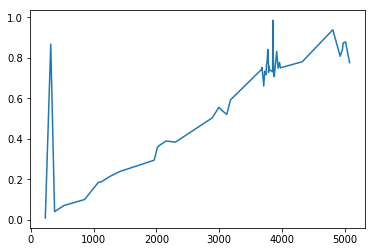

In [627]:
plt.plot(temp['requests'], temp['pod_util_cpu_sum'] )

In [634]:
#dfApp = getAndCombineAllDbs(host, port, username, password,appNames, folderNames)
appName = 'mixallapp'+ "_"+ 'mixallapp' + ".csv"
#dfApp['total_cpu_util'] = dfApp['pod_util_cpu_avg']*dfApp['num_pods']
#dfApp['total_mem_util'] = dfApp['pod_util_mem_avg']*dfApp['num_pods']
dfApp.to_csv(appName)

In [8]:
appName = 'mixallapp'+ "_"+ 'mixallapp' + ".csv"
df = pd.read_csv(appName, header=0, index_col=0)


In [9]:
df.head()

,requests,requests_duration_mean,num_pods,pod_cpu_limit,node_cores,node_mem,pod_mem_limit,pod_util_cpu_sum,pod_util_mem_sum,service
0,1.0,1117.241838,2,0.1,4.0,15.674213,0.097656,0.09,0.907305,serveapp
1,1.0,1117.241838,2,0.1,4.0,15.674213,0.097656,0.02,0.303594,webacapp
2,1.0,1117.241838,2,0.1,4.0,15.674213,0.097656,0.21,0.384805,primeapp
3,15.0,0.101236,1,0.1,2.0,7.799198,0.097656,0.04,0.493320,serveapp
4,16.0,0.054204,3,0.1,4.0,15.674213,0.097656,0.09,0.490273,primeapp


In [543]:
#df = df.loc[df['pod_cpu_limit'] == 2]
#df = df.loc[df['num_pods'] == 1]
#df = df.loc[df['node_cores'] == 4]
#df = df.loc[df['total_cpu_util'] > 1]

df['requests'] =  df['requests']/60

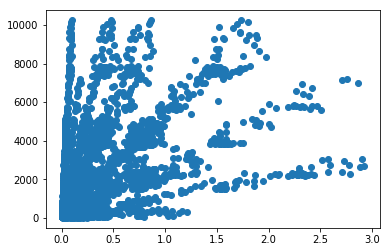

In [10]:
plt.scatter( df['pod_util_cpu_sum'], df['requests'])

In [545]:
#df = dftemp

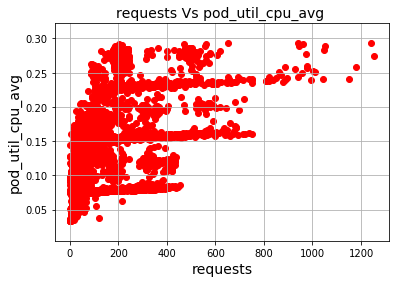

In [546]:
df = df.sort_values(['requests'])
plt.scatter(df['requests'], df['total_mem_util'], color='red')
plt.title('requests Vs pod_util_cpu_avg ', fontsize=14)
plt.xlabel('requests', fontsize=14)
plt.ylabel('pod_util_cpu_avg', fontsize=14)
plt.grid(True)
plt.show()

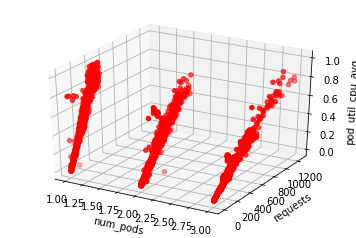

In [547]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['num_pods'],  df['requests'],  df['pod_util_cpu_avg'], c='r', marker='o')

ax.set_xlabel('num_pods')
ax.set_ylabel('requests')
ax.set_zlabel('pod_util_cpu_avg')

plt.show()

In [548]:
from sklearn.linear_model import TheilSenRegressor
from sklearn.datasets import make_regression

df_X = df[['total_cpu_util']].values
df_Y = df[['requests']].values

#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(df_Y)
#df_Y = pd.DataFrame(x_scaled)


X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)

X, y = make_regression(n_samples=df_X.shape[0], n_features=1, noise=5.0, random_state=0)
reg = TheilSenRegressor(random_state=0).fit(df_X, df_Y)
reg.score(X, y)
y_pred = reg.predict(df_X)
print('RMs score: %.2f' % sqrt(mean_squared_error(df_Y, y_pred)))

C:\Users\ansjin\Anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMs score: 44.43


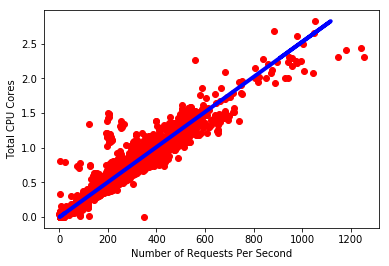

In [551]:
%matplotlib inline
#plt.rcParams['figure.figsize'] = 15, 6
plt.ylabel('Total CPU Cores')
plt.xlabel('Number of Requests Per Second')
#plt.title('serveapp CPU Cores vs Requests per Minute')


plt.scatter( df_Y,df_X[:,0],  color='red')
plt.plot(reg.predict(df_X), df_X[:,0],  color='blue', linewidth=4.0)
plt.savefig('serveapp.png')

In [459]:
reg.predict([[1]])[0]

77.850605923257078

In [485]:
#brute-force-training
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ARDRegression, LinearRegression
from sklearn import svm

appNames = ['webacapp']
df['total_cpu_util'] = df['pod_util_cpu_avg']*df['num_pods']
df['total_mem_util'] = df['pod_util_mem_avg']*df['num_pods']
df_X = df[['total_cpu_util','total_mem_util']].values
df_Y = df[['requests']].values

#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(df_Y)
#df_Y = pd.DataFrame(x_scaled)


X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)
polybig_features = PolynomialFeatures(degree=1, include_bias=False)
std_scaler = StandardScaler()
lin_reg = linear_model.LinearRegression(normalize=True)
regr = Pipeline([
    ("poly_features", polybig_features),
    ("std_scaler", std_scaler),
    ("lin_reg", lin_reg),
])
regr.fit(df_X, df_Y)
#clf = ARDRegression(threshold_lambda=1e5)
#clf.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(df_X)

#rbf_svc = svm.SVC(kernel='linear')
#rbf_svc.fit(X_train, y_train)
#clf = ARDRegression(threshold_lambda=1e5)
#clf.fit(X_train, y_train)
# Make predictions using the testing set
#y_predrbf_svc = rbf_svc.predict(X_test)
#reg = linear_model.LassoLars(alpha=.1)
#reg.fit(X_train, y_train)

# The coefficients

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(df_Y, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df_Y, y_pred))

#print ('Test score %.2f', regr.score(X_test, y_test) )
print("Train Mean squared error: %.2f"
      % mean_squared_error(df_Y, regr.predict(df_X)))
rms = sqrt(mean_squared_error(df_Y, y_pred))
print('RMs score: %.2f' % rms)
#print('RMs score: %.2f' % sqrt(mean_squared_error(y_test, clf.predict(X_test))))
#print('RMs score: %.2f' % sqrt(mean_squared_error(y_test, reg.predict(X_test))))
#print('RMs score: %.2f' % sqrt(mean_squared_error(y_test, y_predrbf_svc)))

Mean squared error: 67.00
Variance score: 0.97
Train Mean squared error: 67.00
RMs score: 8.19


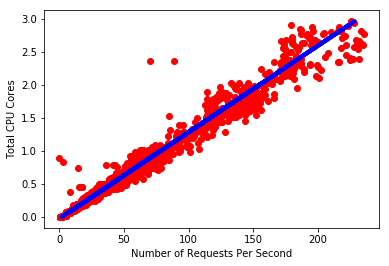

In [488]:
%matplotlib inline
#plt.rcParams['figure.figsize'] = 15, 6
plt.ylabel('Total CPU Cores')
plt.xlabel('Number of Requests Per Second')
#plt.title('serveapp CPU Cores vs Requests per Minute')


plt.scatter( df_Y,df_X[:,0],  color='red')
plt.plot(y_pred, df_X[:,0],  color='blue', linewidth=4.0)
plt.savefig('primeapp.png')

In [476]:
regr.predict([[2,1]])[0][0]

154.97076761425757

In [ ]:
min_max_scaler.inverse_transform(prd)


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
colors = ['teal', 'yellowgreen', 'gold','teal', 'yellowgreen', 'gold','teal', 'yellowgreen', 'gold']
lw = 2
for count, degree in enumerate([3, 4, 5, 6, 7, 8, 9]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, y_pred))
    print('RMs score: %.2f' % rms)
    plt.plot(X_test, y_pred, color=colors[count], linewidth=lw,
             label="degree %d" % degree)
    plt.plot(X_test, y_test, color="blue", linewidth=1,
             label="degree %d" % degree)


In [ ]:

plt.plot(y_pred)

In [ ]:
regr.predict([[1,1,1,3,1000]])

In [ ]:
df.shape

In [ ]:
from sklearn.svm import SVR
appNames = [mainServiceName]
df = df.sort_values(['pod_util_cpu_avg'])
df_X = df[['pod_util_cpu_avg','pod_cpu_limit','pod_mem_limit', 'num_pods', 'requests_duration_mean']].values
df_Y = df[['requests']].values
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)

clf = SVR(kernel='linear', C=1e3)
clf.fit(X_train, y_train)

y_predsvr_rbf = clf.predict(X_test)

rms = sqrt(mean_squared_error(y_test, y_predsvr_rbf))
print('RMs score: %.2f' % rms)


In [ ]:
svr_poly.predict([[2,2,2,1]])

In [ ]:
df['total_cpu_util'] = df['pod_util_cpu_avg']*df['num_pods']
df['total_mem_util'] = df['pod_util_mem_avg']*df['num_pods']

In [ ]:
df.head()

In [ ]:
df = df.sort_values(['requests'])
plt.scatter(df['requests'], df['total_cpu_util'], color='red')
plt.title('requests Vs total_cpu_util ', fontsize=14)
plt.xlabel('requests', fontsize=14)
plt.ylabel('total_cpu_util', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
#train-replicas

filename = "/app/training/preTrainedReplicas/"+appType+"/"+appName+"/"+mainServiceName+"/"+instanceFamily+"/"+"trained.sav"
appNames = ['webacapp']

df_X = df[['requests']].values
df_Y = df[['total_cpu_util']].values
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)
lin_reg = linear_model.LinearRegression()
regr = Pipeline([
    ("lin_reg", lin_reg),
])
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients

rms = sqrt(mean_squared_error(y_test, y_pred))
print('RMs score: %.2f' % rms)

In [ ]:
regr.predict([[21240]])

In [ ]:
appNames = ['primeapp']
folderNames = ['s1t1rc1nc1t2smallcomputeprimeapp100vz7']
df = getAndCombineAllDbs(host, port, username, password,appNames, folderNames)
df = df.sort_values(['pod_util_cpu_avg'])
df

In [ ]:
if(appType == "compute"):
    df_X = df[['pod_util_cpu_avg']].values
else:
    df_X = df[['pod_util_cpu_avg']].values

df_Y = df[['requests']].values
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)
polybig_features = PolynomialFeatures(degree=3, include_bias=False)
std_scaler = StandardScaler()
lin_reg = linear_model.LinearRegression()
regr = Pipeline([
    ("poly_features", polybig_features),
    ("std_scaler", std_scaler),
    ("lin_reg", lin_reg),
])
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
rms = sqrt(mean_squared_error(y_test, y_pred))
print('RMs score: %.2f' % rms)

In [ ]:
df.shape[0]

In [ ]:
#smart-test-train 
#folderNamesPrimeapp = get_folder_names(appNamesConst[1], colName, dbName)
#for folderName in folderNamesPrimeapp:
appNames = ['serveapp']
folderNames = ['s1t1rc1nc2t2xlargesandboxserveapp500rx7']
df = getAndCombineAllDbs(host, port, username, password,appNames, folderNames)
df['total_cpu_util'] = df['pod_util_cpu_avg']*df['num_pods']
df['total_mem_util'] = df['pod_util_mem_avg']*df['num_pods']
if(df.shape[0] < 15):
    testSize = 0
else:
    testSize = 0.33
df = df.head(46)

df_X = df[['total_cpu_util']].values

df_Y = df[['requests']].values
if(df.shape[0] < 15):
    testSize = 0
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=testSize, random_state=42)
    X_test = X_train
    y_test = y_train

else:
    testSize = 0.33
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=testSize, random_state=42)


polybig_features = PolynomialFeatures(degree=3, include_bias=False)
std_scaler = StandardScaler()
lin_reg = linear_model.LinearRegression()
regr = Pipeline([
    ("lin_reg", lin_reg),
])
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
rms = sqrt(mean_squared_error(y_test, y_pred))
print('RMs score: %.2f' % rms)


In [ ]:
regr.predict([[1]])

In [ ]:
#smart-test-train prediction
numcoresUtil = urlparse.parse_qs(parsed.query)['numcoresutil'][0]
numcoresLimit = urlparse.parse_qs(parsed.query)['numcoreslimit'][0]
nummemLimit = urlparse.parse_qs(parsed.query)['nummemlimit'][0]
folderName = urlparse.parse_qs(parsed.query)['containerName'][0]
filename = "/app/training/smartTest/"+appType+"/"+appName+"/"+mainServiceName+"/"+instanceFamily+"/"+folderName+".sav"
loaded_model = pickle.load(open(filename, 'rb'))
val = [[]]
if(appType=="compute"):
    val = [[float(numcoresUtil),float(requestDuration)]]
else:
    val = [[float(numcoresUtil),float(requestDuration)]]

predict = loaded_model.predict(val)
output=""+str(predict[0][0])
print (predict)
print (output)


In [632]:
 #actual trn
folderName = 's1t1rc1nc1t2xlargesandboxserveapp5007pm'
appNames = ['serveapp']
folderNames = [folderName]
df = getAndCombineAllDbs(host, port, username, password,appNames, folderNames)

hit=0
finaldf = df
idxt = 0
for idxt, valt in enumerate(df['requests_duration_mean']):
    if(valt > float(requestDuration)):
        hit+=1
        print(valt)
    if(hit >=10):
        break
if(hit==0):
    for idxt, valt in enumerate(df['pod_util_cpu_avg']):
        threshhold = df['pod_cpu_limit'][idxt] - 0.3*df['pod_cpu_limit'][idxt]
        if(valt > threshhold):
            hit+=1
            print (valt)
        if(hit >=10):
            break
finaldf = df.head(idxt)
finaldf= finaldf.sort_values(['requests'])
val = float(finaldf.tail(1).requests)
output=""+str(val)
print (val)
print (output)

FolderNames len =  1
s1t1rc1nc1t2xlargesandboxserveapp5007pm
All Dfs len =  1
2199.1659553061163
2174.960113743407
2156.6076649611714
2180.554553486086
2155.7108846877804
2076.832702337904
2147.1719698307415
1253.4017432612927
2157.7389753856924
1299.7840468991112
9546.0
9546.0


C:\Users\ansjin\Anaconda\lib\site-packages\ipykernel_launcher.py:343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ansjin\Anaconda\lib\site-packages\ipykernel_launcher.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
requestDuration

In [609]:
df['pod_util_cpu_avg']

0     0.005
1     0.010
2     0.024
3     0.047
4     0.042
5     0.047
6     0.054
7     0.066
8     0.089
9     0.100
10    0.087
11    0.097
12    0.124
13    0.150
14    0.119
15    0.107
16    0.144
17    0.166
18    0.185
19    0.146
20    0.169
21    0.158
22    0.196
23    0.218
24    0.204
25    0.216
26    0.206
27    0.223
28    0.230
29    0.250
      ...  
32    0.276
33    0.253
34    0.294
35    0.294
36    0.328
37    0.320
38    0.299
39    0.336
40    0.316
41    0.266
42    0.333
43    0.323
44    0.383
45    0.380
46    0.330
47    0.358
48    0.348
49    0.401
50    0.410
51    0.371
52    0.373
53    0.372
54    0.379
55    0.387
56    0.441
57    0.478
58    0.414
59    0.459
60    0.356
61    0.398
Name: pod_util_cpu_avg, Length: 62, dtype: float64